# Programming Assignment: Build a CNN for image recognition.

### Name: XinTong Yu
### Student ID: 20033118


## 0. You will do the following:

1. Read, complete, and run the code.

2. **Make substantial improvements** to maximize the accuracy.
    
3. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain the code and the output after execution.
    
    * Missing **the output after execution** will not be graded.


4. Upload the .HTML file to your Google Drive, Dropbox, or Github repo. (If you submit the file to Google Drive or Dropbox, you must make the file "open-access". The delay caused by "deny of access" may result in late penalty.)

4. On Canvas, submit the Google Drive/Dropbox/Github link to the HTML file.


## Requirements:

1. You can use whatever CNN architecture, including VGG, Inception, and ResNet. However, you must build the networks layer by layer. You must NOT import the archetectures from ```keras.applications```.

2. Make sure ```BatchNormalization``` is between a ```Conv```/```Dense``` layer and an ```activation``` layer.

3. If you want to regularize a ```Conv```/```Dense``` layer, you should place a ```Dropout``` layer **before** the ```Conv```/```Dense``` layer.

4. An accuracy above 70% is considered reasonable. An accuracy above 80% is considered good. Without data augmentation, achieving 80% accuracy is difficult.


## Google Colab

- If you do not have GPU, the training of a CNN can be slow. Google Colab is a good option.

- Keep in mind that you must download it as an IPYNB file and then use IPython Notebook to convert it to HTML.

- Also keep in mind that the IPYNB and HTML files must contain the outputs. (Otherwise, the instructor will not be able to know the correctness and performance.) Do the followings to keep the outputs.

- In Colab, go to ```Runtime``` --> ```Change runtime type``` --> Do NOT check ```Omit code cell output when saving this notebook```. In this way, the downloaded IPYNB file contains the outputs.

## 1. Data preparation

### 1.1. Load data


In [21]:
import numpy as np
import pickle
import os

# Path to the dataset
data_dir = './cifar-10-batches-py'

# Function to load a single batch
def load_batch(filepath):
    with open(filepath, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        data = dict[b'data']
        labels = dict[b'labels']
        data = data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
        return data, np.array(labels)

# Load training data (5 batches)
x_train = []
y_train = []
for i in range(1, 6):
    batch_path = os.path.join(data_dir, f'data_batch_{i}')
    data, labels = load_batch(batch_path)
    x_train.append(data)
    y_train.append(labels)
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train).reshape(-1, 1)

# Load test data
x_test, y_test = load_batch(os.path.join(data_dir, 'test_batch'))
y_test = y_test.reshape(-1, 1)

# Print shapes for verification
print('Shape of x_train:', x_train.shape)  # Expected: (50000, 32, 32, 3)
print('Shape of y_train:', y_train.shape)  # Expected: (50000, 1)
print('Shape of x_test:', x_test.shape)    # Expected: (10000, 32, 32, 3)
print('Shape of y_test:', y_test.shape)    # Expected: (10000, 1)

Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)
Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


### 1.2. One-hot encode the labels

In the input, a label is a scalar in $\{0, 1, \cdots , 9\}$. One-hot encode transform such a scalar to a $10$-dim vector. E.g., a scalar ```y_train[j]=3``` is transformed to the vector ```y_train_vec[j]=[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]```.

1. Define a function ```to_one_hot``` that transforms an $n\times 1$ array to a $n\times 10$ matrix.

2. Apply the function to ```y_train``` and ```y_test```.

In [22]:
def to_one_hot(y, num_class=10):
    return np.eye(num_class)[y.reshape(-1)]

y_train_vec = to_one_hot(y_train)
y_test_vec = to_one_hot(y_test)

print('Shape of y_train_vec:', y_train_vec.shape)  # (50000, 10)
print('Shape of y_test_vec:', y_test_vec.shape)    # (10000, 10)
print('Example label:', y_train[0])
print('One-hot encoded:', y_train_vec[0])

Shape of y_train_vec: (50000, 10)
Shape of y_test_vec: (10000, 10)
Example label: [6]
One-hot encoded: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


#### Remark: the outputs should be
* Shape of y_train_vec: (50000, 10)
* Shape of y_test_vec: (10000, 10)
* [6]
* [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

### 1.3. Randomly partition the training set to training and validation sets

Randomly partition the 50K training samples to 2 sets:
* a training set containing 40K samples
* a validation set containing 10K samples


In [23]:
import numpy as np

# Randomly shuffle the indices
rand_indices = np.random.permutation(50000)

# First 40,000 samples for training, last 10,000 samples for validation
train_indices = rand_indices[:40000]
valid_indices = rand_indices[40000:]

# Extract subsets from the original data
x_tr = x_train[train_indices]
y_tr = y_train_vec[train_indices]

x_val = x_train[valid_indices]
y_val = y_train_vec[valid_indices]

# Print shapes for verification
print('Shape of x_tr:  ', x_tr.shape)   # (40000, 32, 32, 3)
print('Shape of y_tr:  ', y_tr.shape)   # (40000, 10)
print('Shape of x_val: ', x_val.shape)  # (10000, 32, 32, 3)
print('Shape of y_val: ', y_val.shape)  # (10000, 10)

Shape of x_tr:   (40000, 32, 32, 3)
Shape of y_tr:   (40000, 10)
Shape of x_val:  (10000, 32, 32, 3)
Shape of y_val:  (10000, 10)


## 2. Build a CNN and tune its hyper-parameters

1. Build a convolutional neural network model
2. Use the validation data to tune the hyper-parameters (e.g., network structure, and optimization algorithm)
    * Do NOT use test data for hyper-parameter tuning!!!
3. Try to achieve a validation accuracy as high as possible.

### Remark: 

The following CNN is just an example. You are supposed to make **substantial improvements** such as:
* Add more layers.
* Use regularizations, e.g., dropout.
* Use batch normalization.

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
)

model = Sequential()

# Conv Block 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

# Dense Block
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))  # 10 类输出

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Bat  (None, 32, 32, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 16, 16, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 16, 16, 64)       

In [25]:
from tensorflow.keras.optimizers.legacy import Adam

learning_rate = 1e-3

model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)

In [26]:
# Train the model

history = model.fit(
    x_tr, y_tr,
    batch_size=64,
    epochs=20,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/20
625/625 [==============================] - 46s 74ms/step - loss: 1.9963 - accuracy: 0.2219 - val_loss: 1.7330 - val_accuracy: 0.3312
Epoch 2/20
625/625 [==============================] - 41s 66ms/step - loss: 1.7908 - accuracy: 0.2831 - val_loss: 1.9355 - val_accuracy: 0.3372
Epoch 3/20
625/625 [==============================] - 54s 86ms/step - loss: 1.6662 - accuracy: 0.3431 - val_loss: 1.3538 - val_accuracy: 0.5107
Epoch 4/20
625/625 [==============================] - 53s 84ms/step - loss: 1.4928 - accuracy: 0.4263 - val_loss: 1.2094 - val_accuracy: 0.5810
Epoch 5/20
625/625 [==============================] - 51s 82ms/step - loss: 1.3367 - accuracy: 0.4949 - val_loss: 1.1218 - val_accuracy: 0.6160
Epoch 6/20
625/625 [==============================] - 59s 94ms/step - loss: 1.2166 - accuracy: 0.5545 - val_loss: 1.4288 - val_accuracy: 0.5275
Epoch 7/20
625/625 [==============================] - 60s 96ms/step - loss: 1.0951 - accuracy: 0.6075 - val_loss: 0.9847 - val_accuracy:

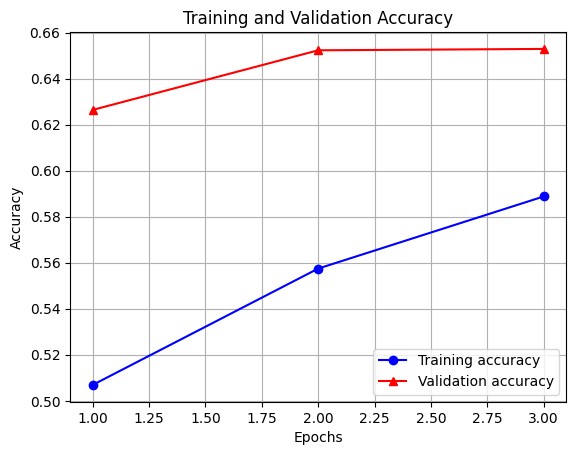

In [14]:
# Plot training and validation accuracy

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r^-', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

## 3. Train (again) and evaluate the model

- To this end, you have found the "best" hyper-parameters. 
- Now, fix the hyper-parameters and train the network on the entire training set (all the 50K training samples)
- Evaluate your model on the test set.

### 3.1. Train the model on the entire training set

Why? Previously, you used 40K samples for training; you wasted 10K samples for the sake of hyper-parameter tuning. Now you already know the hyper-parameters, so why not using all the 50K samples for training?

In [27]:
# Retrain the model on the full training set (50k samples)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers.legacy import Adam

model_full = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model_full.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# Combine training and validation sets to form the full training set
x_train_full = np.concatenate((x_tr, x_val), axis=0)
y_train_full = np.concatenate((y_tr, y_val), axis=0)

# Retrain the model on the full training set
history_full = model_full.fit(
    x_train_full, y_train_full,
    batch_size=64,
    epochs=20,
    verbose=1
)

Epoch 1/20
782/782 [==============================] - 10s 12ms/step - loss: 2.2182 - accuracy: 0.3016
Epoch 2/20
782/782 [==============================] - 10s 12ms/step - loss: 1.3758 - accuracy: 0.5032
Epoch 3/20
782/782 [==============================] - 10s 13ms/step - loss: 1.1999 - accuracy: 0.5744
Epoch 4/20
782/782 [==============================] - 10s 12ms/step - loss: 1.0886 - accuracy: 0.6173
Epoch 5/20
782/782 [==============================] - 10s 13ms/step - loss: 1.0155 - accuracy: 0.6451
Epoch 6/20
782/782 [==============================] - 9s 12ms/step - loss: 0.9557 - accuracy: 0.6664
Epoch 7/20
782/782 [==============================] - 9s 12ms/step - loss: 0.8944 - accuracy: 0.6855
Epoch 8/20
782/782 [==============================] - 11s 14ms/step - loss: 0.8435 - accuracy: 0.7076
Epoch 9/20
782/782 [==============================] - 10s 13ms/step - loss: 0.8005 - accuracy: 0.7205
Epoch 10/20
782/782 [==============================] - 11s 13ms/step - loss: 0.7644 

### 3.2. Evaluate the model on the test set

Do NOT used the test set until now. Make sure that your model parameters and hyper-parameters are independent of the test set.

In [28]:
loss_and_acc = model.evaluate(x_test, y_test_vec)
print('loss = ' + str(loss_and_acc[0]))
print('accuracy = ' + str(loss_and_acc[1]))

313/313 [==============================] - 3s 8ms/step - loss: 0.6717 - accuracy: 0.7699
loss = 0.6716848611831665
accuracy = 0.7699000239372253


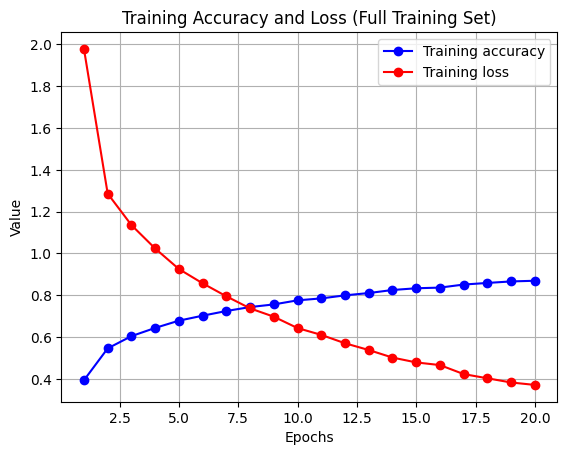

In [20]:
# Plot the loss and accuracy curves from the retraining process
import matplotlib.pyplot as plt

acc = history_full.history['accuracy']
loss = history_full.history['loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo-', label='Training accuracy')
plt.plot(epochs, loss, 'ro-', label='Training loss')
plt.title('Training Accuracy and Loss (Full Training Set)')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()